# 实验一 SVM分类器

In [102]:
import numpy as np
import os
import struct
from matplotlib import pyplot as plt

In [94]:
def load_mnist(path, which='train'):

    if which == 'train':
        labels_path = os.path.join(path, 'train-labels.idx1-ubyte')
        images_path = os.path.join(path, 'train-images.idx3-ubyte')
    elif which == 'test':
        labels_path = os.path.join(path, 't10k-labels.idx1-ubyte')
        images_path = os.path.join(path, 't10k-images.idx3-ubyte')
    else:
        raise AttributeError('`which` must be "train" or "test"')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [95]:
X_train, y_train = load_mnist('/root/codes/SVM/datasets', which='train')
X_test, y_test = load_mnist('/root/codes/SVM/datasets', which='test')
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
np.max(X_train)

255.0

In [96]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 55000
num_validation = 5000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (55000, 784)
Train labels shape:  (55000,)
Validation data shape:  (5000, 784)
Validation labels shape:  (5000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


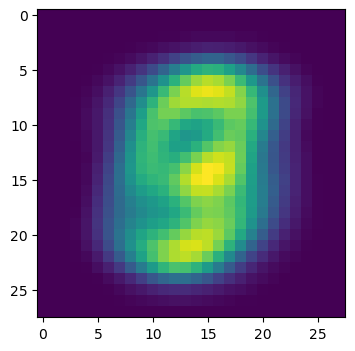

(55000, 785) (5000, 785) (10000, 785) (500, 785)


In [97]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])  # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((28, 28)).astype(
    'uint8'))  # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [98]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    num_classes = W.shape[1]
    num_train = X.shape[0]

    scores = X.dot(W)
    correct_class_scores = scores[range(num_train), y].reshape(num_train, 1)
    margins = np.maximum(scores-correct_class_scores+1, 0)
    loss = margins.sum() / num_train - 1 + reg * np.sum(W * W)
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dW = (margins > 0).astype(int)
    dW[range(num_train), y] -= dW.sum(axis=1)
    dW = (X.T).dot(dW) / num_train + reg * 2 * W

    return loss, dW


class LinearClassifier(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            mask = np.random.choice(X.shape[0], batch_size)
            X_batch = X[mask]
            y_batch = y[mask]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= learning_rate * grad

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(X.dot(self.W), axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [99]:
svm = LinearSVM()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 208.077459
iteration 100 / 1500: loss 73.303923


iteration 200 / 1500: loss 27.809077
iteration 300 / 1500: loss 11.059808
iteration 400 / 1500: loss 5.335306
iteration 500 / 1500: loss 3.119929
iteration 600 / 1500: loss 2.574738
iteration 700 / 1500: loss 2.084027
iteration 800 / 1500: loss 1.882053
iteration 900 / 1500: loss 1.841725
iteration 1000 / 1500: loss 1.679817
iteration 1100 / 1500: loss 1.803087
iteration 1200 / 1500: loss 2.258969
iteration 1300 / 1500: loss 2.094833
iteration 1400 / 1500: loss 1.871119


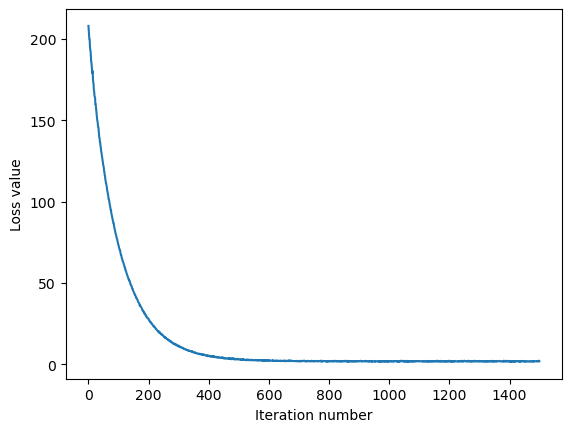

In [100]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [101]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.868909
validation accuracy: 0.900800
